# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize

In [3]:
import sys
sys.path.append("../smote_cd/")
from smote_cd.dataset_generation import softmax

In [4]:
import dirichlet_regression

In [5]:
from scipy.optimize import fmin, newton, minimize

# With Arctic Lake

In [6]:
def f_arctic(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #alpha = np.copy(mu)
    #for i in range(mu.shape[-1]):
    #    alpha[:,i] = phi*mu[:,i]
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [7]:
arctic = pd.read_csv('ArcticLake.csv')

In [8]:
Y_arctic = arctic.iloc[:,:3]
X_arctic = arctic.iloc[:,3]

In [9]:
Y_arctic = np.array(Y_arctic)

In [10]:
X_arctic = np.array([[j] for j in X_arctic])

In [11]:
Z_arctic = np.ones(len(X_arctic)).reshape((39,1))

In [12]:
n_features = 1
n_classes = 3

In [13]:
beta0 = np.array([[0., 0.05, 0.06]])
gamma0 = [0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [14]:
%%time
solution_arctic_bis=minimize(f_arctic, params0, args=(X_arctic, Y_arctic, Z_arctic))

Wall time: 218 ms


In [15]:
solution_arctic_bis.message

'Optimization terminated successfully.'

In [16]:
beta_arctic = solution_arctic_bis.x[:n_features*n_classes].reshape((n_features,n_classes))

In [17]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

In [18]:
mu_arctic = dirichlet_regression.compute_mu(X_new, beta_arctic)

gamma_var_arctic = solution_arctic_bis.x[n_features*n_classes:]
phi_arctic = np.exp(np.matmul(Z_arctic,gamma_var_arctic))

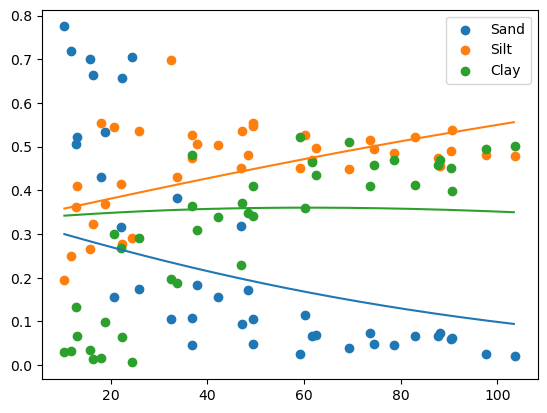

In [19]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic)
plt.legend()
plt.show()

In [21]:
r2_score(Y_arctic,dirichlet_regression.compute_mu(X_arctic, beta_arctic))

0.1516210994933588

### With an intercept

In [23]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [24]:
beta0 = np.array([[0., -0.3, -1.1],[ 0., 0.05, 0.06]])
gamma0 = [0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [25]:
%%time
solution_arctic_bis=minimize(f_arctic, params0, args=(X_arctic_1, Y_arctic, Z_arctic))

Wall time: 1.19 s


In [26]:
solution_arctic_bis

      fun: -77.72809940037273
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.41928661e-02,  3.79588273e-03,
         0.00000000e+00, -8.74525750e-04, -4.44068275e-04,
        -3.71142165e-02],
       [ 0.00000000e+00,  3.79588273e-03,  2.66957540e-02,
         0.00000000e+00, -2.89778158e-04, -6.11830060e-04,
        -3.02018525e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -8.74525750e-04, -2.89778158e-04,
         0.00000000e+00,  3.06878133e-05,  2.13015134e-05,
         1.13361593e-03],
       [ 0.00000000e+00, -4.44068275e-04, -6.11830060e-04,
         0.00000000e+00,  2.13015134e-05,  2.51980907e-05,
         1.03459667e-03],
       [ 0.00000000e+00, -3.71142165e-02, -3.02018525e-02,
         0.00000000e+00,  1.13361593

In [27]:
beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

In [28]:
X_new_1 = np.arange(10.4,103.7,0.5)
X_new_1 = np.array([[1., j] for j in X_new_1])

In [29]:
mu_arctic_1 = dirichlet_regression.compute_mu(X_new_1, beta_arctic_1)

gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:]
phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))

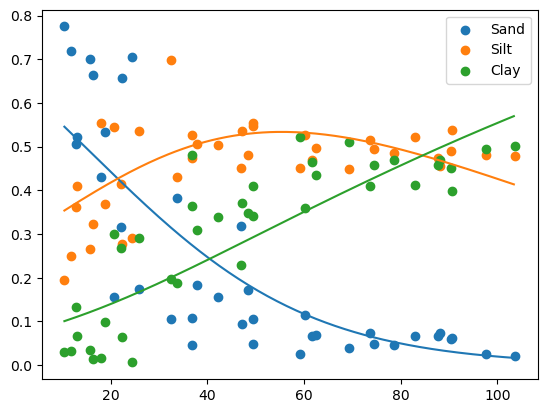

In [30]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_1)
plt.legend()
plt.show()

In [31]:
r2_score(Y_arctic,dirichlet_regression.compute_mu(X_arctic_1, beta_arctic_1))

0.5886602081584336

## With X^2

In [32]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [33]:
beta0 = np.array([[ 0., -1.5, -4.], [0, 0.05, 0.1], [0., 0.01, 0.01]])
gamma0 = [2.]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [34]:
%%time
solution_arctic_bis=minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic))

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


Wall time: 1.41 s


In [35]:
solution_arctic_bis.message

'Desired error not necessarily achieved due to precision loss.'

In [36]:
beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [37]:
beta_arctic_2

array([[ 0.00000000e+00, -1.74783164e+00, -4.15660182e+00],
       [ 0.00000000e+00,  9.50075487e-02,  1.55216378e-01],
       [ 0.00000000e+00, -5.86263289e-04, -9.61258250e-04]])

In [38]:
X_new_2 = np.arange(10.4,103.7,0.5)
X_new_2 = np.array([[1., j, j**2] for j in X_new_2])

In [44]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:]
phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

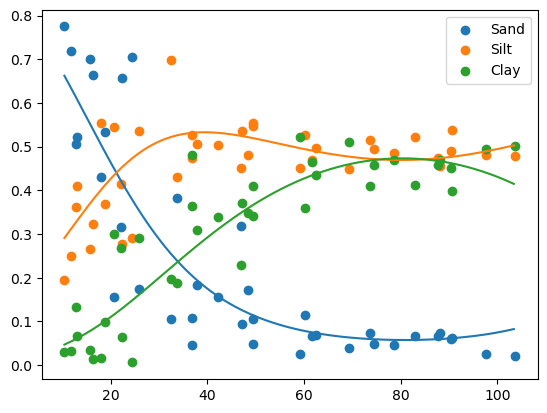

In [40]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [41]:
r2_score(Y_arctic,dirichlet_regression.compute_mu(X_arctic_2, beta_arctic_2))

0.678294856397245

In [47]:
dirichlet_regression.dirichlet_loglikelihood(dirichlet_regression.compute_mu(X_arctic_2, beta_arctic_2),phi_arctic_2,Y_arctic)

91.28038171066616

# Using the derivatives

In [101]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [88]:
def fprime_arctic(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #beta_grad = dirichlet_regression.dirichlet_gradient(mu, X, Y, epsilon=epsilon)
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [89]:
h=0.000001
params0_h = np.copy(params0)
params0_h[-2] += h 
(f_arctic(params0_h, X_arctic_2, Y_arctic, Z_arctic)-f_arctic(params0, X_arctic_2, Y_arctic, Z_arctic))/h

271402.53057746124

In [90]:
fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic)

array([-0.00000000e+00,  2.44803858e+00,  4.54959527e+01, -0.00000000e+00,
       -1.40671295e+03,  3.41001611e+03, -0.00000000e+00, -1.49382795e+05,
        2.71310732e+05,  4.12946026e+01])

In [91]:
%%time
solution_arctic = minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic), jac=fprime_arctic)

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


Wall time: 437 ms


In [92]:
solution_arctic.message

'Desired error not necessarily achieved due to precision loss.'

In [93]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [94]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

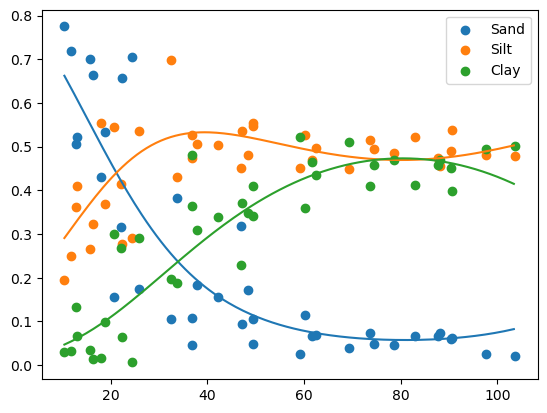

In [97]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

## My GD

In [98]:
params0

array([ 0.  , -1.5 , -4.  ,  0.  ,  0.05,  0.1 ,  0.  ,  0.01,  0.01,
        2.  ])

In [196]:
def gradientDescent(X, Y, Z, params_0, learning_rate=0.001, nitermax=1000, tolmax=1e-3,epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_beta = current_param[:K*J].reshape((K,J))
    current_beta[:,0] = 0
    current_gamma_var = current_param[K*J:]

    while (tol > tolmax) & (niter<nitermax):
        current_phi = np.exp(np.matmul(Z,current_gamma_var))
        current_mu = dirichlet_regression.compute_mu(X, current_beta)
        list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        
        list_gradients.append(grad)
        # we want to maximize the function, so we add the gradient
        old_param = np.copy(current_param)
        current_param = current_param - learning_rate * grad
        current_beta = current_param[:K*J].reshape((K,J))
        current_beta[:,0] = 0
        current_gamma_var = current_param[K*J:]
        current_param = np.concatenate([current_beta.flatten(),current_gamma_var])
        list_params.append(current_param)
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_likelihoods, list_gradients)

In [108]:
%%time
list_params, list_likelihoods, list_gradients=gradientDescent(X_arctic_2_bis, Y_arctic, Z_arctic, 
                                                              params0, 
                                                              nitermax = 5000, learning_rate=2e-2, tolmax=1e-2)

Nb of iterations: 5000
Wall time: 17.2 s


In [109]:
solution_arctic = list_params[-1]

In [110]:
beta_arctic_2 = solution_arctic[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
beta_arctic_2

array([[ 0.        , -0.62426398, -5.69057417],
       [ 0.        ,  8.01092011, 13.41568044],
       [ 0.        , -4.89436202, -9.1511138 ]])

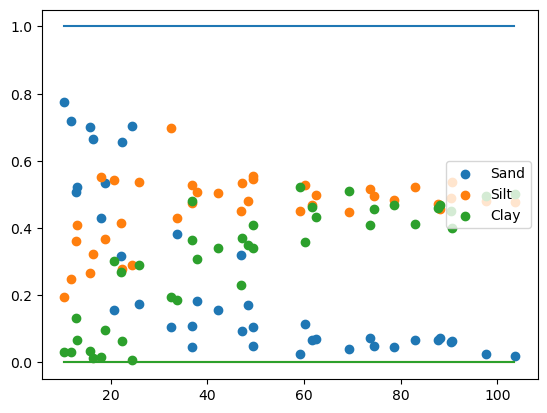

In [111]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

#gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
#phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [112]:
X_new_2_bis = np.arange(10.4,103.7,0.5)
X_new_2_bis = np.array([[1., j/np.max(X_arctic), (j/np.max(X_arctic))**2] for j in X_new_2_bis])

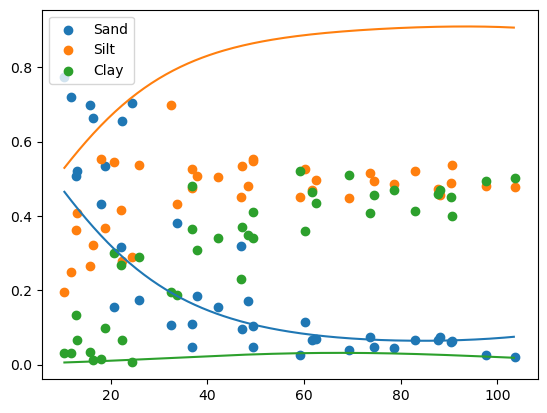

In [113]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2)

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

### With hessian

In [465]:
def fhessian(x, X, Y, Z):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    if len(phi.shape)==1:
        K_phi=1
    else:
        K_phi = phi.shape[-1]
    hessian = np.zeros((K*J+1,K*J+1))
    #beta_hess = dirichlet_regression.dirichlet_hessian_wrt_beta(mu, phi, X, Y).reshape((K*J,K*J))
    beta_hess = dirichlet_hessian_wrt_beta_2(mu, phi, X, Y).reshape((K*J,K*J))
    #gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma(mu, phi, beta, X, Y, Z)
    gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma_2(mu, phi, beta, X, Y, Z)
    #beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma_2(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    
    # we set to 0 the first columns of the betas
    for k in range(0,K*J,J):
        beta_hess[k,:] = 0
        beta_hess[:,k] = 0.
        beta_gamma_derivative[:,k] = 0.
    hessian[:K*J,:K*J] = beta_hess
    hessian[K*J:,K*J:] = gamma_hess
    hessian[:K*J,K*J:] = beta_gamma_derivative.transpose()
    hessian[K*J:,:K*J] = beta_gamma_derivative
    return(-hessian)

In [320]:
fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic)

array([-0.00000000e+00,  2.44803858e+00,  4.54959527e+01, -0.00000000e+00,
       -1.40671295e+03,  3.41001611e+03, -0.00000000e+00, -1.49382795e+05,
        2.71310732e+05,  4.12946026e+01])

In [316]:
h=0.000001
params0_h = np.copy(params0)
params0_h[5] += h 
(fprime_arctic(params0_h, X_arctic_2, Y_arctic, Z_arctic)-fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic))/h

array([ 0.00000000e+00, -1.98728330e+03,  1.99227742e+03,  0.00000000e+00,
       -8.67261840e+04,  8.67582302e+04,  0.00000000e+00, -4.04627617e+06,
        4.04609504e+06,  1.90396482e+03])

In [317]:
test_hess = fhessian(params0, X_arctic_2, Y_arctic, Z_arctic)

In [466]:
%%time
solution_arctic = minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic), jac=fprime_arctic, hess=fhessian, method='newton-cg', tol=1e-8)

Wall time: 3.72 s


In [467]:
solution_arctic.message

'Optimization terminated successfully.'

In [468]:
solution_arctic.x

array([ 0.00000000e+00, -1.58878800e+00, -3.95380850e+00,  0.00000000e+00,
        8.73567665e-02,  1.46257966e-01,  0.00000000e+00, -5.22072385e-04,
       -8.87909711e-04,  2.88269991e+00])

In [469]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

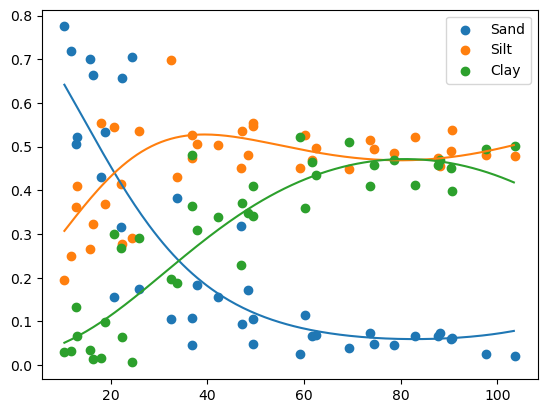

In [470]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

## My GD with hessian

In [86]:
def gradientDescentNewton(X, Y, Z, params_0, nitermax=1000, tolmax=1e-3,epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_beta = current_param[:K*J].reshape((K,J))
    current_beta[:,0] = 0
    current_gamma_var = current_param[K*J:]

    while (tol > tolmax) & (niter<nitermax):
        current_phi = np.exp(np.matmul(Z,current_gamma_var))
        current_mu = dirichlet_regression.compute_mu(X, current_beta)
        list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        
        hess = fhessian(current_param, X, Y, Z)
        hess_inv = np.linalg.pinv(hess)
        
        list_gradients.append(grad)
        # we want to maximize the function, so we add the gradient
        old_param = np.copy(current_param)
        print(np.matmul(hess_inv,grad))
        current_param = current_param - np.matmul(hess_inv,grad)
        current_beta = current_param[:K*J].reshape((K,J))
        current_beta[:,0] = 0
        current_gamma_var = current_param[K*J:]
        current_param = np.concatenate([current_beta.flatten(),current_gamma_var])
        print('---')
        print(current_param)
        list_params.append(current_param)
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_likelihoods, list_gradients)

In [315]:
%%time
list_params, list_likelihoods, list_gradients=gradientDescentNewton(X_arctic_2, Y_arctic, Z_arctic, 
                                                              params0, nitermax = 1000, tolmax=1e-4)

[ 0.00000000e+00 -2.43508328e+04 -2.46927060e+04 -8.53629308e-08
  3.45521684e+03  3.47671845e+03 -5.26314627e-09 -1.12512217e+02
 -1.12783211e+02 -4.93392233e+01]
---
[    0.         24349.33279153 24688.7060191      0.
 -3455.16683808 -3476.61844663     0.           112.52221747
   112.79321107    51.33922326]


C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:15: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:18: RuntimeWarning: invalid value encountered in true_divide
  mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  I_n = np.identity(n)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\AppData\Local\Temp\ipykernel_12280\3350967127.py:68: RuntimeWarning: overflow encountered in double_scalars
  phi_trigamma_alpha_c = phi[i]*trigamma_alpha[c]
C:\Users\46660461\AppData\Local\Temp\ipykernel_12280\3350967127.py:69: RuntimeWarning: invalid value encountered in double_scalars
  hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*l

LinAlgError: SVD did not converge

In [110]:
beta_test = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02],  
                      [0.00000000e+00, 5.37880187e+02, -3.71678045e+03] , 
                      [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])

In [111]:
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2,beta_test)

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


In [112]:
phi_test = np.exp(np.matmul(Z_arctic,[-1.54306869e+00]))

In [593]:
phi_test[8]*mu_test[8]

array([False, False, False])

In [113]:
def trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/(z+n)**2
    return S

def z_times_trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/( z + 2*n + (n**2)/z )
    return S

def a_times_trigamma_func(a,z):
    S=0
    try:
        for n in range(10000):
            S+=1/( z*(z/a) + (2*z*n)/a + (n**2)/a )
    except ZeroDivisionError:
        S=1e305
    return S

In [510]:
a_times_trigamma_func(0.2, 2e-247)

1e+305

In [236]:
def dirichlet_hessian_wrt_beta_2(mu, phi, X, Y, alpha=None, epsilon=0):
    K = np.shape(X)[1] #nb of features
    J = np.shape(Y)[1] #nb of classes
    n = np.shape(Y)[0] 
    hessian = np.zeros((K,J,K,J))
    if alpha is None:
        alpha = np.copy(mu)
        for j in range(J):
            alpha[:,j] = phi*mu[:,j]
    for i in range(n):
        digamma_alpha = digamma(alpha[i])
        digamma_alpha[np.isinf(digamma_alpha)] = -1e305

        trigamma_alpha = polygamma(1,alpha[i])
        trigamma_alpha[np.isinf(trigamma_alpha)] = 1e305
        
        #mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #if math.isinf(trigamma_alpha):
        #    mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #else:
        mu_2_trigamma = mu[i]**2*trigamma_alpha
        mu_2_trigamma[mu[i]**2==0] = 0
        phi_sum_mu_2_trigamma = phi[i]*np.sum(mu_2_trigamma)
        
        logY = np.log(Y[i]+epsilon)
        sum_mu_log = 2*np.sum(mu[i]*logY)
        
        mu_digamma_alpha = mu[i]*digamma_alpha
        mu_digamma_alpha[mu[i]==0] = 0
        sum_mu_digamma = 2*np.sum(mu_digamma_alpha)
        
        mu_digamma_log = mu[i]*(digamma_alpha-logY)
        #mu_digamma_log[mu[i]==0] = 0
        sum_mu_digamma_log = np.sum(mu_digamma_log)
        for p in range(K):
            phi_Xip = phi[i]*X[i,p]
            for d in range(J):
                phi_Xip_muid = phi_Xip*mu[i,d]
                if alpha[i,d]==0:
                    alpha_times_trigamma_alpha = np.zeros(np.shape(trigamma_alpha[d]))
                else:
                    if math.isinf(trigamma_alpha[d]):
                        alpha_times_trigamma_alpha = np.array(a_times_trigamma_func(alpha[i,d],alpha[i,d]))
                    else:
                        alpha_times_trigamma_alpha = alpha[i,d]*trigamma_alpha[d]
                for q in range(K):
                    phi_Xip_muid_Xiq = phi_Xip_muid*X[i,q]
                    for c in range(J):
                        if c!=d:
                            if alpha[i,c]==0:
                                alpha_c_trigamma_alpha_c = 0
                            elif math.isinf(trigamma_alpha[c]):
                                alpha_c_trigamma_alpha_c = a_times_trigamma_func(alpha[i,c],alpha[i,c])
                            else:
                                alpha_c_trigamma_alpha_c = alpha[i,c]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( digamma_alpha[c] + digamma_alpha[d]
                                                                           - logY[c] - logY[d]
                                                                           + alpha_c_trigamma_alpha_c + alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma 
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma )
                        else:
                            
                            if math.isinf(trigamma_alpha[c]):
                                #phi_trigamma_alpha_c = np.array(a_times_trigamma_func(phi[i],alpha[i,c]))
                                phi_trigamma_alpha_c = phi[i]*1e305
                            else:
                                phi_trigamma_alpha_c = phi[i]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*logY[c] 
                                                                           + 2*alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma
                                                                           - phi_trigamma_alpha_c)
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq * (sum_mu_digamma_log - digamma_alpha[c] + logY[c] )
    # fill the symmetric values we didn't compute
    #for p in range(K):
    #    for d in range(J):
    #        for q in range(p):
    #            for c in range(J):
    #                hessian[p,d,q,c] = hessian[q,c,p,d]
    return hessian

In [486]:
%%time
_ = dirichlet_regression.dirichlet_hessian_wrt_beta(mu_test, phi_test, X_arctic_2_bis, Y_arctic)

Wall time: 10 ms


In [108]:
mu_test_bis = np.array([1.04578539e-246, 2.54998312e-298, 1.00000000e+000])
mu_test_bis**2

array([0., 0., 1.])

In [211]:
beta_test = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02], 
                                                               [0.00000000e+00, 5.37880187e+02, -3.71678045e+03], 
                                                               [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2_bis,beta_test)
phi_test = np.exp(np.matmul(Z_arctic,[-1.54306869e+00]))

In [237]:
%%time
dirichlet_hessian_wrt_beta_2(mu_test, phi_test, X_arctic_2_bis, Y_arctic)

Wall time: 1.37 ms


array([[[[ 5.11823194e+00,  5.47337622e-01, -5.66556957e+00],
         [ 2.45255953e-01,  4.16876520e-01, -6.62132473e-01],
         [-2.57690694e-01,  3.23948082e-01, -6.62573887e-02]],

        [[ 5.47337622e-01,  8.45266218e+00, -8.99999980e+00],
         [ 4.16876520e-01,  9.07135012e-01, -1.32401153e+00],
         [ 3.23948082e-01, -1.20087834e-01, -2.03860248e-01]],

        [[-5.66556957e+00, -8.99999980e+00,  1.46655694e+01],
         [-6.62132473e-01, -1.32401153e+00,  1.98614401e+00],
         [-6.62573887e-02, -2.03860248e-01,  2.70117637e-01]]],


       [[[ 2.45255953e-01,  4.16876520e-01, -6.62132473e-01],
         [-2.57690694e-01,  3.23948082e-01, -6.62573887e-02],
         [-2.52820277e-01,  2.55093768e-01, -2.27349083e-03]],

        [[ 4.16876520e-01,  9.07135012e-01, -1.32401153e+00],
         [ 3.23948082e-01, -1.20087834e-01, -2.03860248e-01],
         [ 2.55093768e-01, -2.22396854e-01, -3.26969134e-02]],

        [[-6.62132473e-01, -1.32401153e+00,  1.98614401e+0

In [238]:
%%time
dirichlet_regression.dirichlet_second_derivative_beta_gamma_2(mu_test, phi_test, beta_test, X_arctic_2_bis, Y_arctic, Z_arctic)

Wall time: 3.01 ms


array([[[  5.93566426,   9.07093694, -15.0066012 ],
        [  0.71990516,   1.37673711,  -2.09664227],
        [  0.06164781,   0.24427255,  -0.30592035]]])

In [241]:
test_param = np.array([ 0.00000000e+00, -1.68702777e+02,  9.11259508e+02,  0.00000000e+00,
  5.37880187e+02, -3.71678045e+03,  0.00000000e+00, -4.06042729e+02,
  2.77243089e+03, -1.54306869e+00])
fhessian(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -8.45266218e+00,  8.99999980e+00,
        -0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -9.07093694e+00],
       [-0.00000000e+00,  8.99999980e+00, -1.46655694e+01,
        -0.00000000e+00,  1.32401153e+00, -1.98614401e+00,
        -0.00000000e+00,  2.03860248e-01, -2.70117637e-01,
         1.50066012e+01],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -0.00000000e+00,  2.22396854e-01,  3.26969134e-02,
        -1.

In [310]:
fprime_arctic(test_param_h, X_arctic_2, Y_arctic, Z_arctic)

[[1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  I_n = np.identity(n)


array([-0.00000000e+00, -3.90000000e+01,  7.80000000e+01, -0.00000000e+00,
       -1.87350000e+03,  3.74700000e+03, -0.00000000e+00, -1.19953910e+05,
        2.39907820e+05, -6.47185147e+01])

In [321]:
fprime_arctic(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)

array([ -0.        , -12.38383635,   3.38132457,  -0.        ,
        -0.38892245, -10.29110409,  -0.        ,   0.75062587,
        -9.58037658, -59.93704478])

In [312]:
test_param

array([ 0.00000000e+00, -1.68702777e+02,  9.11259508e+02,  0.00000000e+00,
        5.37880187e+02, -3.71678045e+03,  0.00000000e+00, -4.06042729e+02,
        2.77243089e+03, -1.54306869e+00])

In [329]:
h=0.0000001
test_param_h = np.copy(test_param)
test_param_h[4] += h 
(fprime_arctic(test_param_h, X_arctic_2_bis, Y_arctic, Z_arctic)-fprime_arctic(test_param, X_arctic_2_bis, Y_arctic, Z_arctic))/h

array([ 0.        ,  0.41687633,  0.        ,  0.        ,  0.32394787,
        0.        ,  0.        ,  0.25509361,  0.        , -0.05272561])

In [324]:
test_hess = fhessian(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)
test_hess

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -8.45266218e+00,  8.99999980e+00,
        -0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -9.07093694e+00],
       [-0.00000000e+00,  8.99999980e+00, -1.46655694e+01,
        -0.00000000e+00,  1.32401153e+00, -1.98614401e+00,
        -0.00000000e+00,  2.03860248e-01, -2.70117637e-01,
         1.50066012e+01],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -0.00000000e+00,  2.22396854e-01,  3.26969134e-02,
        -1.

In [320]:
test_beta = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02],  [0.00000000e+00,
  5.37880187e+02, -3.71678045e+03],  [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2_bis, test_beta)

In [285]:
solution_arctic = list_params[-1]

beta_arctic_2 = solution_arctic[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
beta_arctic_2

array([[ 0.00000000e+00, -4.81525199e+00, -6.95162005e+00],
       [ 0.00000000e+00,  4.94488327e-01,  5.17653466e-01],
       [ 0.00000000e+00, -5.34681144e-03, -4.97890760e-03]])

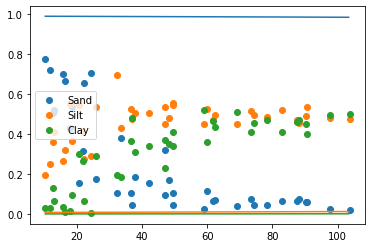

In [286]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2)

#gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
#phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

# Conjugate gradient

In [231]:
from scipy.optimize import line_search

In [283]:
def conjugate_gradient(X, Y, Z, params_0, nitermax=1000, tolmax=1e-3, epsilon=0, method='f-r'):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_gamma_var = current_param[K*J:]
    current_phi = np.exp(np.matmul(Z,current_gamma_var))
    if len(current_phi.shape)==1:
        K_phi=1
    else:
        K_phi = current_phi.shape[-1]
        
    old_grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
    d = -old_grad

    while (tol > tolmax) & (niter<nitermax):
        current_beta = current_param[:K*J].reshape((K,J))
        current_beta[:,0] = 0
        current_gamma_var = current_param[K*J:]
        current_phi = np.exp(np.matmul(Z,current_gamma_var))
        current_mu = dirichlet_regression.compute_mu(X, current_beta)
        list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        #hess = fhessian(current_param, X, Y, Z)
        
        if method=='f-r':
            # Fletcher-Reeves
            beta = np.dot(grad,grad)/np.dot(old_grad,old_grad)
        else:
            # Polak-Ribiere
            beta = np.dot(grad,grad-old_grad)/np.dot(old_grad,old_grad)
            
        d = -grad + beta*d
        
        old_param = current_param
        alpha = line_search(f_arctic, fprime_arctic, current_param, d, args=(X,Y,Z))[0]
        if alpha is None:
            break
        current_param = old_param + alpha*d
        list_params.append(current_param)
        
        list_gradients.append(grad)
        old_grad = grad
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_likelihoods, list_gradients)

In [303]:
beta0_bis = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0_bis = [0.]
params0_bis = np.concatenate([beta0_bis.flatten(),gamma0_bis])

In [318]:
solution_arctic_bis=minimize(f_arctic, params0_bis, args=(X_arctic_2_bis, Y_arctic, Z_arctic))

In [319]:
params_warmup = solution_arctic_bis.x

In [320]:
list_params_CG, list_likelihoods_CG, list_gradients_CG = conjugate_gradient(X_arctic_2_bis, Y_arctic, Z_arctic, params_warmup, nitermax=50, tolmax=1e-2,epsilon=0)

Nb of iterations: 1


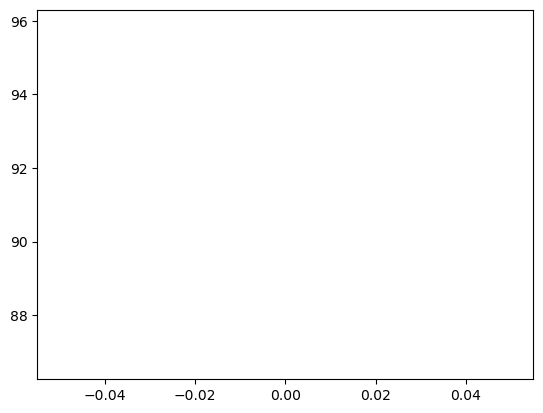

In [322]:
plt.plot(list_likelihoods_CG)
plt.show()

In [323]:
list_likelihoods_CG[-1]

91.28039303422757

In [324]:
list_params_CG[-1]

array([  0.        ,  -1.74709554,  -4.15554564,   0.        ,
         9.84676799,  16.08942908,   0.        ,  -6.2986645 ,
       -10.33044399,   2.94593828])

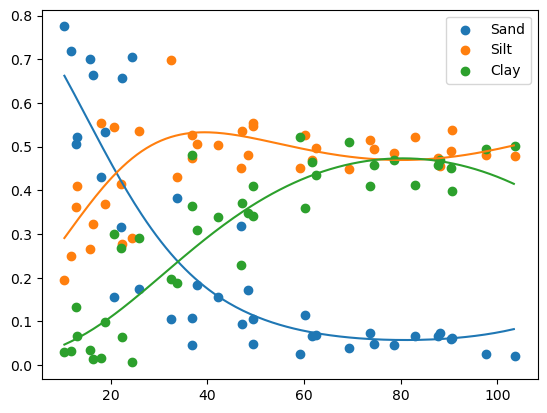

In [325]:
solution_arctic_CG = list_params_CG[-1]
beta_arctic_2_CG = solution_arctic_CG[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

X_new_2_bis = np.arange(10.4,103.7,0.5)
X_new_2_bis = np.array([[1., j/np.max(X_arctic), (j/np.max(X_arctic))**2] for j in X_new_2_bis])

mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2_CG)

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [520]:
def f_test(x):
    x1,x2 = x
    return 0.5 * x1**2 + x2**2 - 5*x2

def grad_f_test(x):
    x1,x2 = x
    return np.array([x1,2*x2-5])

#def grad_f_test(x):
#    x1,x2 = x
#    return np.array([2*x1**3 - 3*x1**2 - 100,100*x2])

In [521]:
x1_test = np.linspace(-10, 10, 100)
x2_test = np.linspace(-10, 10, 100)
x1v, x2v = np.meshgrid(x1_test, x2_test)

In [522]:
%%time
list_eval = []
for x1, x2 in zip(x1v.flatten(), x2v.flatten()):
    list_eval.append(f_test([x1,x2]))

Wall time: 14 ms


<IPython.core.display.Javascript object>


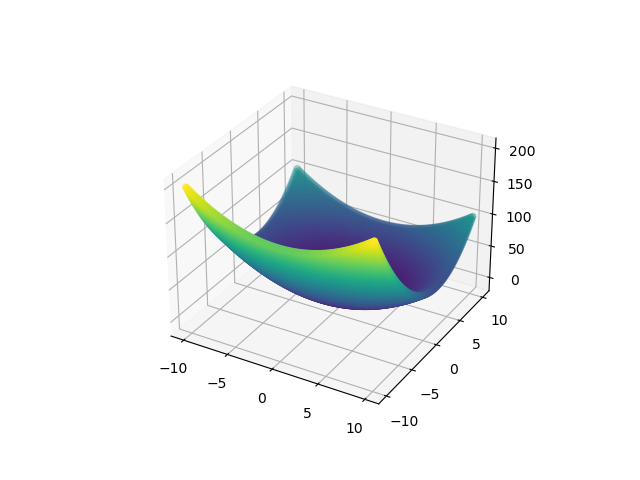

In [523]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(x1v.flatten(), x2v.flatten(), np.array(list_eval), c=list_eval)
plt.show()

In [529]:
minimize(f_test, np.array([5.,5.]))

      fun: -6.24999999999918
 hess_inv: array([[1.00720373, 0.00446786],
       [0.00446786, 0.50277195]])
      jac: array([-9.53674316e-07, -1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([-9.48224914e-07,  2.49999939e+00])

In [525]:
def conjugate_gradient_test(params_0, nitermax=1000, tolmax=1e-3, epsilon=0, method='f-r'):
    current_param = params_0
    list_params = [current_param]
    list_gradients = []
    
    niter=0
    tol=1
        
    old_grad = grad_f_test(current_param)
    d = -old_grad

    while (tol > tolmax) & (niter<nitermax):
        grad = grad_f_test(current_param)
        
        if method=='f-r':
            # Fletcher-Reeves
            beta = np.dot(grad,grad)/np.dot(old_grad,old_grad)
        else:
            # Polak-Ribiere
            beta = np.dot(grad,grad-old_grad)/np.dot(old_grad,old_grad)
            
        d = -grad + beta*d
        
        old_param = current_param
        alpha = line_search(f_test, grad_f_test, current_param, d)[0]
        if alpha is None:
            print("C'est tchao")
            break
        current_param = old_param + alpha*d
        list_params.append(current_param)
        
        list_gradients.append(grad)
        old_grad = grad
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_gradients)

In [530]:
l_param_test, _ = conjugate_gradient_test(np.array([5.,5.]), tolmax=1e-5)

Nb of iterations: 32


In [532]:
l_param_test[-1]

array([6.35669957e-06, 2.50000317e+00])

# With premade root function

In [254]:
from scipy.optimize import root

In [266]:
%%time
solution_arctic = root(fprime_arctic, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic), jac=fhessian)

Wall time: 111 ms


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:109: RuntimeWarning: invalid value encountered in multiply
  mu_2_trigamma = mu[i]**2*trigamma_alpha
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:135: RuntimeWarning: invalid value encountered in double_scalars
  hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( digamma_alpha[c] + digamma_alpha[d]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:142: RuntimeWarning: invalid value encountered in double_scalars
  hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*logY[c]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:90: RuntimeWarning: invalid value encountered in multiply
  phi[i]*np.sum( mu[i]**2*polygamma(1,phi_mu) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:170: RuntimeWarning: invalid value encountered in double_scalars
  temp_d = mu[i,d]*( logYi[d] - digamma_phi_mu[d] - mu[i,d]*phi[i]*trigamma_phi_mu[d

In [267]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

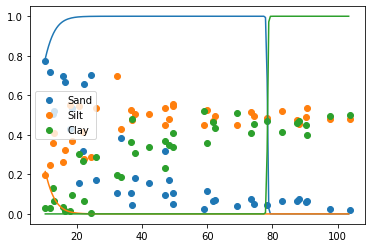

In [268]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2)

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

# With Maupiti data ?

In [306]:
X_maupiti = pd.read_csv('../../Maupiti/maupiti_X_13244.csv', index_col=0)
Y_maupiti = pd.read_csv('../../Maupiti/maupiti_Y_13244.csv',index_col=0)

In [307]:
n_features = X_maupiti.shape[1]
n_classes = Y_maupiti.shape[1]
n_samples = X_maupiti.shape[0]

In [308]:
X_maupiti = np.array(X_maupiti)
Y_maupiti = np.array(Y_maupiti)

In [272]:
#X_maupiti = X_maupiti/10000

In [309]:
np.shape(X_maupiti)

(13244, 16)

In [310]:
#X_maupiti_2 = np.ones((n_samples,1+n_features*2))
#X_maupiti_2[:,1:1+n_features] = X_maupiti
#X_maupiti_2[:,1+n_features:] = X_maupiti**2

X_maupiti_1 = np.ones((n_samples,1+n_features))
X_maupiti_1[:,1:] = X_maupiti

In [311]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [312]:
Z_maupiti = np.ones(np.shape(X_maupiti))

In [313]:
beta_maupiti = np.ones((1+n_features)*n_classes+(1+n_features))[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))
beta_maupiti[:,0] = 0

In [314]:
gamma_maupiti = np.zeros(X_maupiti.shape[-1])

In [315]:
params0_maupiti = np.concatenate([beta_maupiti.flatten(),gamma_maupiti])

In [320]:
X_maupiti_train = X_maupiti_1[6000:8000,:]
Y_star_maupiti_train = Y_star_maupiti[6000:8000,:]
Z_maupiti_train = Z_maupiti[6000:8000]

In [321]:
np.shape(X_maupiti_train)

(2000, 17)

In [324]:
%%time
solution_maupiti = fmin(f_arctic, params0_maupiti, args=(X_maupiti_train, Y_star_maupiti_train, Z_maupiti_train), maxiter=50)

Wall time: 6min 15s


In [325]:
solution_maupiti

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [268]:
beta_maupiti = solution_maupiti.x[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))

In [269]:
beta_maupiti

array([[ 0.00000000e+00,  4.99299173e-04, -9.92816950e-03,
        -4.90916518e-03, -3.14375881e-03,  1.35856612e-04,
         1.61801106e-02, -5.85262338e-03, -3.98790709e-03,
         9.84511811e-03],
       [ 0.00000000e+00, -1.52674183e-01, -3.51204391e-03,
        -2.79715141e-02, -2.53530410e-02, -1.06069316e-02,
         4.38541883e-02, -1.81879339e-02, -2.20893628e-02,
         5.93632023e-03],
       [ 0.00000000e+00, -1.16346092e-03,  8.85194672e-04,
        -2.47973126e-04, -2.73424886e-04, -1.23027363e-04,
        -2.25141896e-04, -1.77564207e-04, -2.47764618e-04,
        -5.61045503e-04],
       [ 0.00000000e+00, -3.18958825e+03,  3.54575871e+02,
         7.69334716e+01,  8.84176126e+01,  1.29788878e+02,
         4.12553852e+02,  3.86396801e+01,  9.04032704e+01,
        -2.32198146e+02],
       [ 0.00000000e+00,  1.26449216e+02, -3.13434834e+01,
         2.68660343e+01,  4.04829567e+01,  3.48466679e+01,
         1.40990452e+02, -1.33240171e+00,  2.51639866e+01,
         1.

In [270]:
mu_maupiti = dirichlet_regression.compute_mu(X_maupiti_train, beta_maupiti)

gamma_var_maupiti = solution_maupiti.x[(1+n_features)*n_classes:]
phi_maupiti = np.exp(np.matmul(Z_maupiti_train,gamma_var_maupiti))

alpha_maupiti = np.copy(mu_maupiti)
for i in range(mu_maupiti.shape[-1]):
    alpha_maupiti[:,i] = phi_maupiti*mu_maupiti[:,i]

In [271]:
dirichlet_regression.dirichlet_loglikelihood(mu_maupiti,phi_maupiti,Y_star_maupiti_train)

568016.0466597767

In [272]:
mu_maupiti

array([[0.09644161, 0.12903978, 0.09011342, ..., 0.09555541, 0.09553641,
        0.10940674],
       [0.10071373, 0.09361845, 0.10009911, ..., 0.09940176, 0.0997901 ,
        0.09929323],
       [0.10168829, 0.09285406, 0.10425783, ..., 0.09797322, 0.09864558,
        0.0981441 ],
       ...,
       [0.10127855, 0.09226994, 0.10093602, ..., 0.09921769, 0.09964512,
        0.0983244 ],
       [0.10051239, 0.08505605, 0.09909841, ..., 0.10024391, 0.10075606,
        0.10270675],
       [0.09406436, 0.14661619, 0.08691615, ..., 0.0921553 , 0.09285731,
        0.10862155]])

In [273]:
r2_score(Y_star_maupiti_train, mu_maupiti)

-0.255171521040826

# With Arctic Lake

## Attractor to see the convergence

In [28]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [29]:
beta0 = np.array([[ 0., -1.5, -4.], [0, 0.05, 0.1], [0., 0.01, 0.01]])
gamma0 = [2.]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [169]:
beta0_bis = np.array([[ 0., -1., -1.], [0, 0., 0.1], [0., 0., 0.]])
gamma0_bis = [1.]
params0_bis = np.concatenate([beta0_bis.flatten(),gamma0_bis])

In [79]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [176]:
list_params[-1]

array([ 0.00000000e+00, -1.74887530e+00, -4.15768166e+00,  0.00000000e+00,
        9.50578429e-02,  1.55266591e-01,  0.00000000e+00, -5.86727078e-04,
       -9.61698050e-04,  2.94607829e+00])

In [80]:
beta0 = np.array([[0., -0.3, -1.1],[ 0., 0.05, 0.06]])
gamma0 = [0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [46]:
def callbackF(Xi):
    global list_params
    #global Nfeval
    #print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2]))
    #Nfeval += 1
    list_params.append(XiX_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [210]:
%%time
list_params = []
solution_arctic_bis=minimize(f_arctic, params0_bis, args=(X_arctic_2_bis, Y_arctic, Z_arctic), callback=callbackF)
list_params = np.array(list_params)

Wall time: 537 ms


In [211]:
solution_arctic_bis.message

'Optimization terminated successfully.'

<IPython.core.display.Javascript object>


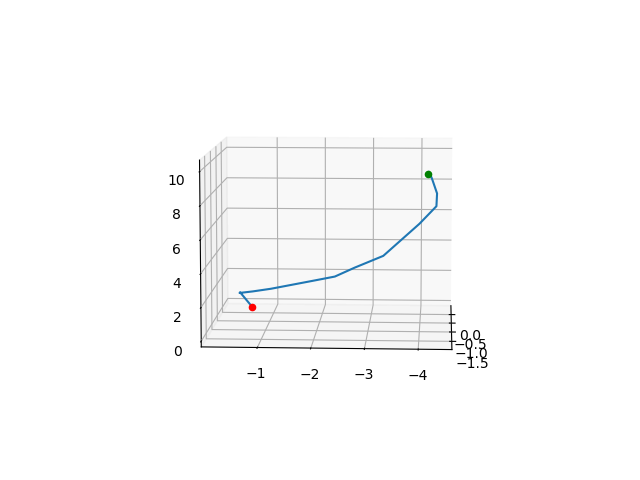

In [212]:
%matplotlib notebook
ax = plt.figure().add_subplot(projection='3d')

x1,x2,x3 = 1,2,4
ax.plot(list_params[:,x1],list_params[:,x2],list_params[:,x3])
ax.scatter(list_params[0,x1],list_params[0,x2],list_params[0,x3],c='r')
ax.scatter(list_params[-1,x1],list_params[-1,x2],list_params[-1,x3],c='g')
plt.show()

In [213]:
beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
mu_arctic_2 = dirichlet_regression.compute_mu(X_arctic_2_bis, beta_arctic_2)

In [216]:
gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:]
phi_arctic_2 = np.exp(np.matmul(Z_arctic, gamma_var_arctic_2))

In [218]:
best_ll_bis = dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic)

### Compared with my GD

In [225]:
%%time
list_params_GD, list_likelihoods_GD, _ =gradientDescent(X_arctic_2_bis, Y_arctic, Z_arctic, params0_bis, 
                                      nitermax = 1000, learning_rate=1e-3, tolmax=1e-3)

Nb of iterations: 1000
Wall time: 3.43 s


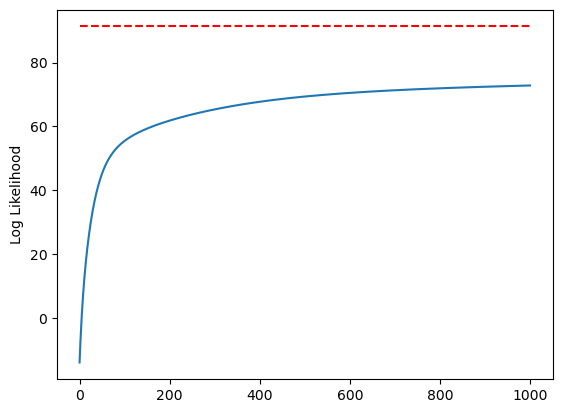

In [227]:
plt.plot(list_likelihoods_GD)
plt.plot([0,1000],[best_ll_bis,best_ll_bis],'r--')
plt.ylabel('Log Likelihood')
plt.show()

In [228]:
list_params_GD = np.array(list_params_GD)

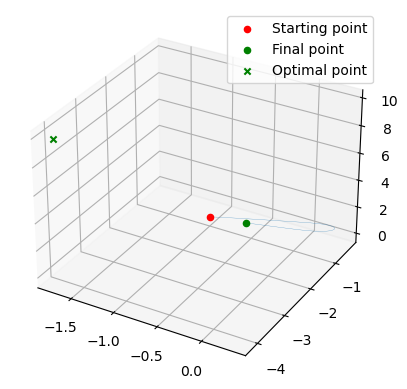

In [229]:
ax = plt.figure().add_subplot(projection='3d')

x1,x2,x3 = 1,2,4
ax.plot(list_params_GD[:,x1],list_params_GD[:,x2],list_params_GD[:,x3],linewidth=.2,alpha=.8)
ax.scatter(list_params_GD[0,x1],list_params_GD[0,x2],list_params_GD[0,x3],c='r',label='Starting point')
ax.scatter(list_params_GD[-1,x1],list_params_GD[-1,x2],list_params_GD[-1,x3],c='g',label='Final point')
ax.scatter(list_params[-1,x1],list_params[-1,x2],list_params[-1,x3],marker='x',c='g',label='Optimal point')
plt.legend()
plt.show()

In [205]:
solution_arctic_GD = list_params_GD[-1]
beta_arctic_2_GD = solution_arctic_GD[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

X_new_2_bis = np.arange(10.4,103.7,0.5)
X_new_2_bis = np.array([[1., j/np.max(X_arctic), (j/np.max(X_arctic))**2] for j in X_new_2_bis])

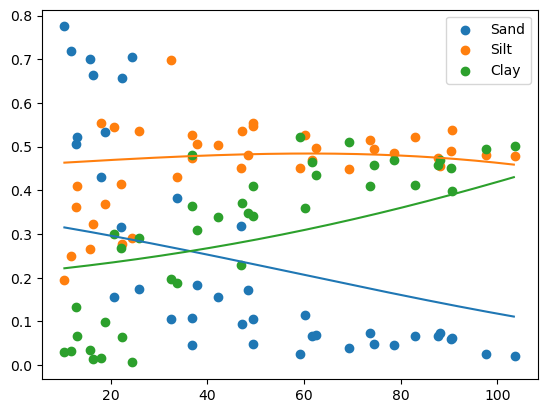

In [206]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2_GD)

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

## What is obtained with DirichletReg on R

In [82]:
beta_true = [[0.02335, 0.05557, 0.0643]]
intercept_true = [[ 0.11662, -0.31060, -1.152]] 

In [83]:
def compute_mu_bis(X, beta, intercept):
    n = np.shape(X)[0]
    J = np.shape(beta)[1]
    Xbeta = np.matmul(X,beta)
    for i in range(n):
        Xbeta[i,:] = Xbeta[i,:]+intercept 
    mu = np.zeros((n,J))
    # compute the softmax
    exp_Xbeta = np.exp(Xbeta)
    sum_exp_Xbeta = np.sum(exp_Xbeta,axis=1)
    for i in range(n):
        mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
    return mu

In [84]:
min(X_arctic),max(X_arctic)

(array([10.4]), array([103.7]))

In [21]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

In [86]:
mu_new = compute_mu_bis(X_new, beta_true, intercept_true)

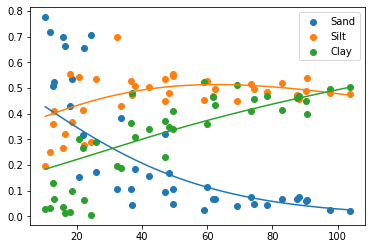

In [87]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_new)
plt.legend()
plt.show()

In [17]:
intercept_true = [[ 1.4361967, -0.0259705, -1.7931487]] 
beta_true = [[-0.0072382, 0.0717450, 0.1107906]]
beta2_true = [[ 0.0001324, -0.0002679, -0.0004872]] 

In [18]:
def compute_mu_ter(X, beta, intercept, beta2):
    n = np.shape(X)[0]
    J = np.shape(beta)[1]
    Xbeta = np.matmul(X,beta)
    X2beta2 = np.matmul(X**2,beta2)
    for i in range(n):
        Xbeta[i,:] = X2beta2[i,:]+Xbeta[i,:]+intercept 
    mu = np.zeros((n,J))
    # compute the softmax
    exp_Xbeta = np.exp(Xbeta)
    sum_exp_Xbeta = np.sum(exp_Xbeta,axis=1)
    for i in range(n):
        mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
    return mu

In [94]:
mu_new = compute_mu_ter(X_new, beta_true, intercept_true, beta2_true)

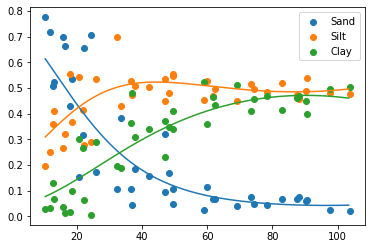

In [95]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_new)
plt.legend()
plt.show()

In [92]:
r2_score(Y_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))

0.6756225377194269

In [93]:
np.sum(Y_arctic,axis=0)

array([ 9.438, 17.818, 11.743])

In [94]:
len(Y_arctic)

39

In [95]:
import smote_cd

In [90]:
X_arctic_os, Y_arctic_os = smote_cd.oversampling_multioutput(X_arctic, Y_arctic)

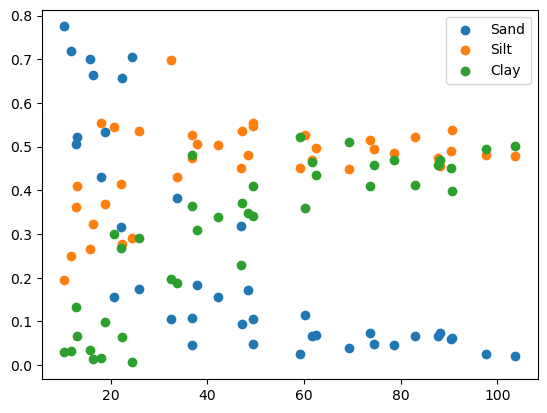

In [93]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
#plt.plot(X_new, mu_new)
plt.legend()
plt.show()

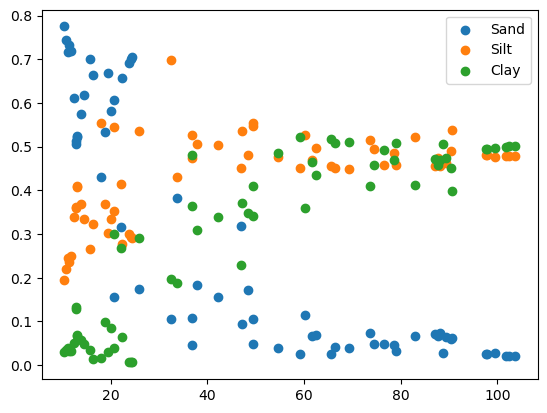

In [92]:
plt.scatter(X_arctic_os,Y_arctic_os[:,0],label='Sand')
plt.scatter(X_arctic_os,Y_arctic_os[:,1],label='Silt')
plt.scatter(X_arctic_os,Y_arctic_os[:,2],label='Clay')
#plt.plot(X_new, mu_new)
plt.legend()
plt.show()

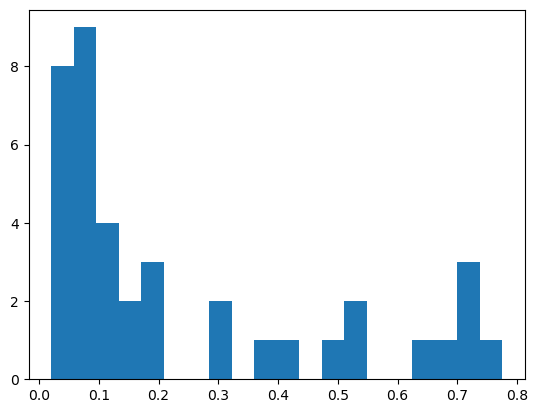

In [101]:
plt.hist(Y_arctic[:,0], bins=20)
plt.show()

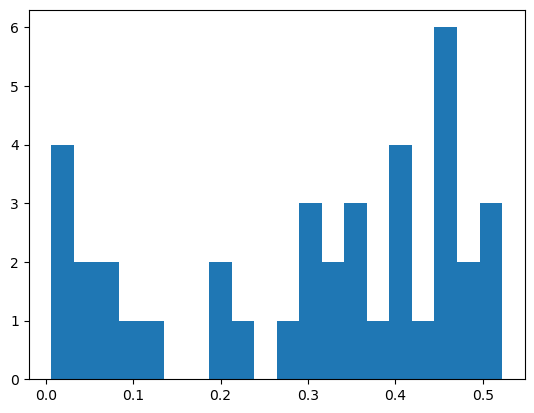

In [100]:
plt.hist(Y_arctic[:,2], bins=20)
plt.show()

In [102]:
np.sum(Y_arctic,axis=0)/np.sum(Y_arctic)

array([0.24200621, 0.45688351, 0.30111028])

In [95]:
np.sum(Y_arctic_os,axis=0)/np.sum(Y_arctic_os)

array([0.28385791, 0.42979667, 0.28634543])

# Comparaison des likelihood

In [46]:
beta_arctic_2

array([[ 5.31504084e-01, -4.90414264e-03, -7.43694690e-01],
       [-7.08068799e-03,  2.17292632e-02,  3.95446102e-02],
       [ 5.27078769e-04,  3.51462021e-04,  2.43649407e-04]])

In [47]:
intercept_true

[[1.4361967, -0.0259705, -1.7931487]]

In [161]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2)

In [102]:
dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2, phi_arctic_2, Y_arctic)

49.05283798414962

In [116]:
dirichlet_regression.dirichlet_loglikelihood(compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true), 
                                             phi_arctic_2, Y_arctic)

54.90714973914159

---

In [79]:
from scipy.special import loggamma

In [88]:
def dirichlet_loglikelihood_no_phi(mu,Y,epsilon=0):
    n = np.shape(Y)[0]
    sum_ll = 0
    for i in range(n):
        term_A = loggamma(np.sum(mu[i]))
        term_B = np.sum(loggamma(mu[i]))
        term_C = np.sum((mu[i]-1)*np.log(Y[i]+epsilon))
        sum_ll += term_A + term_C - term_B
    return sum_ll

In [44]:
r2_score(Y_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))

0.6756225377194269

In [162]:
r2_score(Y_arctic, dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2))

0.5012346539814307

In [54]:
np.log(gamma(1))

0.0

In [163]:
dirichlet_loglikelihood_no_phi(compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true), Y_arctic)

-12.519344575908269

In [164]:
dirichlet_loglikelihood_no_phi(dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2), Y_arctic)

-10.582358302459484

In [83]:
alpha_1 = np.exp(np.matmul(X_arctic_2,beta_arctic_2))

In [84]:
alpha_2 = np.exp(np.matmul(X_arctic_2,np.array([intercept_true[0], beta_true[0], beta2_true[0]])))

In [89]:
dirichlet_loglikelihood_no_phi(alpha_1, Y_arctic)

-673.3460649616601

In [90]:
dirichlet_loglikelihood_no_phi(alpha_2, Y_arctic)

108.77833131416085

In [108]:
true_params = np.array([[0, -1.7471939375, -4.1558203475],
                       [0, 0.0949597540, 0.1551641068],
                       [0,  -0.0005857499, -0.0009607057]])
true_gamma = 2.9464265445
Z = np.ones(39)
true_phi = np.exp(Z*true_gamma)

In [102]:
true_mu_alt = dirichlet_regression.compute_mu(X_arctic_2,true_params)

In [110]:
dirichlet_regression.dirichlet_loglikelihood(true_mu_alt, true_phi, Y_arctic)

91.28038830278896

In [199]:
gamma_var_arctic_2

array([2.94592283])

In [200]:
phi_arctic_2 = np.exp(Z*gamma_var_arctic_2)
mu_arctic_2 = dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2)
dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2, true_phi, Y_arctic)

91.28038768684509

Pourquoi ça ne marchait pas ?

- Dimension de gamma et Z était incorrecte (il faut juste Z de dimension 39,1 et gamma un réel) 
- Arguments de départs : il faut qu'ils soient assez proches de ceux optims, d'où l'échauffement avec BFGS

TODO:

- Clean le code
- Les fonctions de calcul de LL et gradient (normalement c'est bon)